In [1]:
from hepmc import *
import numpy as np

In [2]:
target = densities.Camel(2)

class TestMapping(phase_space.mapping.PhaseSpaceMapping):
    def __init__(self, a, b=None):
        super().__init__(a, b)
        
    def pdf(self, xs):
        xs = util.interpret_array(xs, self.ndim)
        return np.full(xs.shape[0], 1/2)

    def pdf_gradient(self, xs):
        return 0

    def map(self, xs):
        xs = util.interpret_array(xs, self.ndim)
        return xs * 2

    def map_inverse(self, xs):
        xs = util.interpret_array(xs, self.ndim_out)
        return xs / 2

In [3]:
from plotting import *

0.656358 * 1.234065 = 0.809989 ; 0.901686 > 0.809989
0.112136 * 2.982996 = 0.334501 ; 0.700717 > 0.334501
0.141135 * 2.659239 = 0.375312 ; 0.453699 > 0.375312


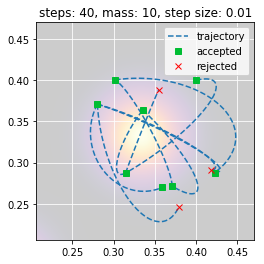

In [4]:
# check mapping works
plot_hmc_traj(phase_space.MappedDensity(target, TestMapping(2, 2)), steps=40)

In [5]:
sarge = densities.Sarge(2, 3, 100.)

In [3]:
sarge.proposal()

array([ 46.64527333,  13.34726437, -23.11443233,  38.25382433,
        19.68714175,  -6.75218651,  17.59144238,  -5.70374285,
        33.66758492,  -6.59507786,   5.52298995, -32.55008148])

In [2]:
eeqqg = densities.ee_qq_1g(100.)

In [5]:
eeqqg.pdf(sarge.proposal(0))

array([0.02397713])

In [6]:
int_sample = ImportanceMC(sarge)(eeqqg, 10000)
int_sample.integral, int_sample.integral_err

(612.6726569213383, 9.106800384338344)

In [3]:
rambo_mapping = phase_space.RamboOnDiet(100., 3)
mapped = phase_space.MappedDensity(eeqqg, rambo_mapping)

In [8]:
int_sample = PlainMC(5)(mapped, 20000)
int_sample.integral, int_sample.integral_err

(509.7277158202, 83.43864985301958)

In [10]:
# just the importance sampling Metroplis sampler (rambo)
met = DefaultMetropolis(5, mapped)
met.sample(1000, np.random.rand(5))

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.07980873 0.32875385 0.82241354 0.60696767 0.40529247],[0.04891502 0.03289125 0.05613446 0.06716204 0.04713533],"2659, p=0, N=2",None,0.034000


In [9]:
# just a local sampler (rambo)
met = DefaultMetropolis(5, mapped, proposals.Gaussian(5, .01))
met.sample(1000, np.random.rand(5))

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.12444717 0.62206627 0.25954564 0.37033714 0.60830796],[0.03614229 0.10201632 0.04254818 0.05800959 0.03578178],"3571, p=0, N=18",None,0.170000


In [10]:
# now sarge + local in MC3
importance = DefaultMetropolis(3 * 4, eeqqg, proposal=sarge)  # using sarge, full momentum sample space
local = DefaultMetropolis(5, mapped, proposals.Gaussian(5, .01))  # using rambo, rambo sample space
update = MixingMarkovUpdate(5, [importance, local], target=mapped,
                            out_maps={0: rambo_mapping.map_inverse},
                            in_maps={0: rambo_mapping.map}) # rambo sample space, important to set target explicitly
sample = update.sample(1000, np.random.rand(5))
sample  # note: to get ESS, set mean and variance of mapped from one of the metropolis runs

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.17446283 0.60416991 0.49012665 0.4551203 0.52624163],[0.07723193 0.07681868 0.08680913 0.07226849 0.07480916],"8107, p=0, N=30",None,0.579000
